# Fitting a double-wilson model to a pair of datasets
## Importing modules

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np

In [120]:
import reciprocalspaceship as rs
import gemmi
from scipy.optimize  import least_squares, minimize
from scipy.stats     import rice, foldnorm, vonmises, linregress, pearsonr
from dw_tools        import fitting_dw, modify_ds

In [121]:
%autosave 300
# !cat /proc/meminfo | grep Mem
%load_ext autoreload
%autoreload 2
rs.__version__

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'0.9.5'

## Loading data

In [147]:
path="double_wilson_data/"    # Unix
data_set_pairs = [("5kvx_phases", "5kw3_phases"),\
                  ("5e1y_phases", "2vwr_phases"),\
                  ("3pyp_phases", "1nwz_phases"),\
                  ("1otb_phases", "1nwz_phases"),\
                  ("4eul_phases", "GFP_SSRL_refine_54_final"),\
                  ("4kjk_phases", "4kjj_phases", "4pst_phases", "4pss_phases"),\
                  ("e35cdef_OFF200ns_HD_2sig_varEll","e35cdef_200ns_HD_2sig_varEll")]
# example 1 fails on kNN regression
example=5
mtz1 = data_set_pairs[example][2] # omit .mtz
mtz2 = data_set_pairs[example][3]
ds1 = rs.read_mtz(path + mtz1 + "_scaled.mtz")
ds2 = rs.read_mtz(path + mtz2 + "_scaled.mtz")

In [148]:
ds1_2 = ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))
ds1_2.label_centrics(inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2, bin_labels = ds1_2.assign_resolution_bins(bins=20, inplace=True, return_labels=True);
# ds1_2.info()

EP1_label = "EP_1_aniso_2_1"
EP2_label = "EP_1_aniso_2_2"
dHKL_label = "dHKL_1"
dHKL_bin_label = "bin"

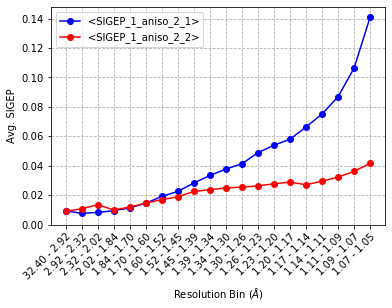

In [149]:
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP1_label].mean()
plt.plot(result,'bo-', label="<SIG" + EP1_label + ">")
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP2_label].mean()
plt.plot(result,'ro-', label="<SIG" + EP2_label + ">")
plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.ylabel("Avg. SIGEP")
plt.grid(linestyle='--')
plt.ylim([0,plt.ylim()[1]]); plt.legend(); plt.show()

Optionally, apply a resolution cutoff.

In [150]:
if True:
    modify_ds.ds_high_res_cut(ds1_2, rescut=1.2, inplace=True)

In [151]:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],\
                          dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print(a)
print(f"a: {a:.4}")
print(f"b: {b:.4}")

`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 2.1013e+00, final cost 5.4617e-02, first-order optimality 4.69e-05.
0.8936756469502001
a: 0.8937
b: 0.2272


## Calculating effective Rice dist parameters per reflection
Consider two data sets of normalized structure factor amplitudes, $\{x\}$ and $\{x+\epsilon+\eta\}$, with the first data set ideal, $\epsilon$ the fixed, true differences between the data sets and $\eta$ the measurement errors. In this case, $\textrm{Cov}(x,x+\epsilon)$ is given by the Double-Wilson distribution, as is $\sigma^2_{x}$. Once we've estimated $a$ and $b$ above such that $r(s)=a\cdot e^{-b s^2}$, we can calculate what value we should use to constrain a prior distribution for another data set by taking into account that our estimates are tainted by measurement error. 

To begin, we'll use the approximate relationship $\rho(|E_1|,|E_2|)=r_{DW}^2$ and the relationship

$\rho^{-2}_{obs}=\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}$,

with $\sigma_x$ known from the Wilson distribution and different between centric and acentric reflections. This equation follows from:

$\rho(x,x+\varepsilon+\eta) = \frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}+\sigma^2_{\eta}}}$
and $\rho_{DW}=\rho(x,x+\varepsilon)=\frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}}}$

Now,

$r_{eff}\approx\sqrt{\rho_{obs}}$   and   $\rho_{obs}=1/\sqrt{\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}}$   and   $\rho_{DW}\approx a^2 e^{-2bs^2}$ and $s=1/d_{HKL}$.

In [152]:
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP1_label, dHKL_label=dHKL_label, inplace=True);
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP2_label, dHKL_label=dHKL_label, inplace=True);

**~ ~ At this point, we're really done. ~ ~**

What follows is additional some inspection.

## Binning by $|E_1|$
Means per bin for $|E_1|$, determined separately for acentrics and centrics.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. We'll set bin labels for both centrics and acentrics here:

In [153]:
nbin=25
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2_centric  = (ds1_2["CENTRIC"].to_numpy()==True)
ds1_2_acentric = (ds1_2["CENTRIC"].to_numpy()==False)

ep1_bins          = np.percentile(ds1_2.loc[ds1_2_acentric, EP1_label], cdf_bins)
ep1_bins[-1]      = ep1_bins[-1]+1e-6                # to avoid omitting the largest data point
ep1_dig           = np.digitize(ds1_2.loc[  ds1_2_acentric, EP1_label], ep1_bins) # note that we're creating bin labels for all reflections, acentric or not

ep1_cent_bins     = np.percentile(ds1_2.loc[ds1_2_centric,  EP1_label], cdf_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6
ep1_cent_dig      = np.digitize(ds1_2.loc[  ds1_2_centric,  EP1_label], ep1_cent_bins) # note that we're creating bin labels for all reflections, acentric or not

ds1_2.loc[ds1_2_acentric, "EP_1_bin"] = ep1_dig.flatten()
ds1_2.loc[ds1_2_centric,  "EP_1_bin"] = ep1_cent_dig.flatten()

Some inspection of the created bins!

Number of reflections per bin (acentric):
{1.0: 1725, 2.0: 1725, 3.0: 1724, 4.0: 1725, 5.0: 1725, 6.0: 1724, 7.0: 1725, 8.0: 1725, 9.0: 1724, 10.0: 1725, 11.0: 1725, 12.0: 1724, 13.0: 1725, 14.0: 1724, 15.0: 1725, 16.0: 1725, 17.0: 1724, 18.0: 1725, 19.0: 1725, 20.0: 1724, 21.0: 1725, 22.0: 1725, 23.0: 1724, 24.0: 1725, 25.0: 1725}

Number of reflections per bin (centric):
{1.0: 179, 2.0: 179, 3.0: 179, 4.0: 179, 5.0: 178, 6.0: 179, 7.0: 179, 8.0: 179, 9.0: 178, 10.0: 179, 11.0: 179, 12.0: 179, 13.0: 178, 14.0: 179, 15.0: 179, 16.0: 179, 17.0: 178, 18.0: 179, 19.0: 179, 20.0: 179, 21.0: 178, 22.0: 179, 23.0: 179, 24.0: 179, 25.0: 179}


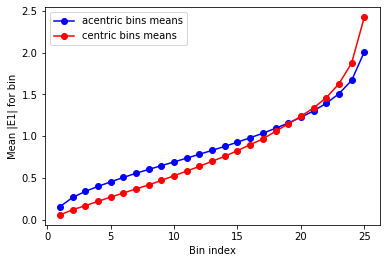

In [154]:
# For acentrics:
unique, counts = np.unique(ds1_2.loc[ds1_2_acentric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):"); print(temp)
print()

# for centrics
unique, counts = np.unique(ds1_2.loc[ds1_2_centric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (centric):");  print(temp)

bin_means_acentric = ds1_2[ds1_2_acentric].groupby("EP_1_bin")[EP1_label].mean()
bin_means_centric  = ds1_2[ds1_2_centric ].groupby("EP_1_bin")[EP1_label].mean()
plt.plot(bin_means_acentric,'bo-',label="acentric bins means")
plt.plot(bin_means_centric, 'ro-',label="centric bins means")
plt.xlabel("Bin index"); plt.ylabel("Mean |E1| for bin")
plt.legend(); plt.show()

## Conditional distribution for Acentrics. Histograms of $|E_2|$ per bin of $|E_1|$.
**Note**: this does not yet use the $a$ and $b$ estimated above.

<ipython-input-156-dfc1d46353eb>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,5,3)


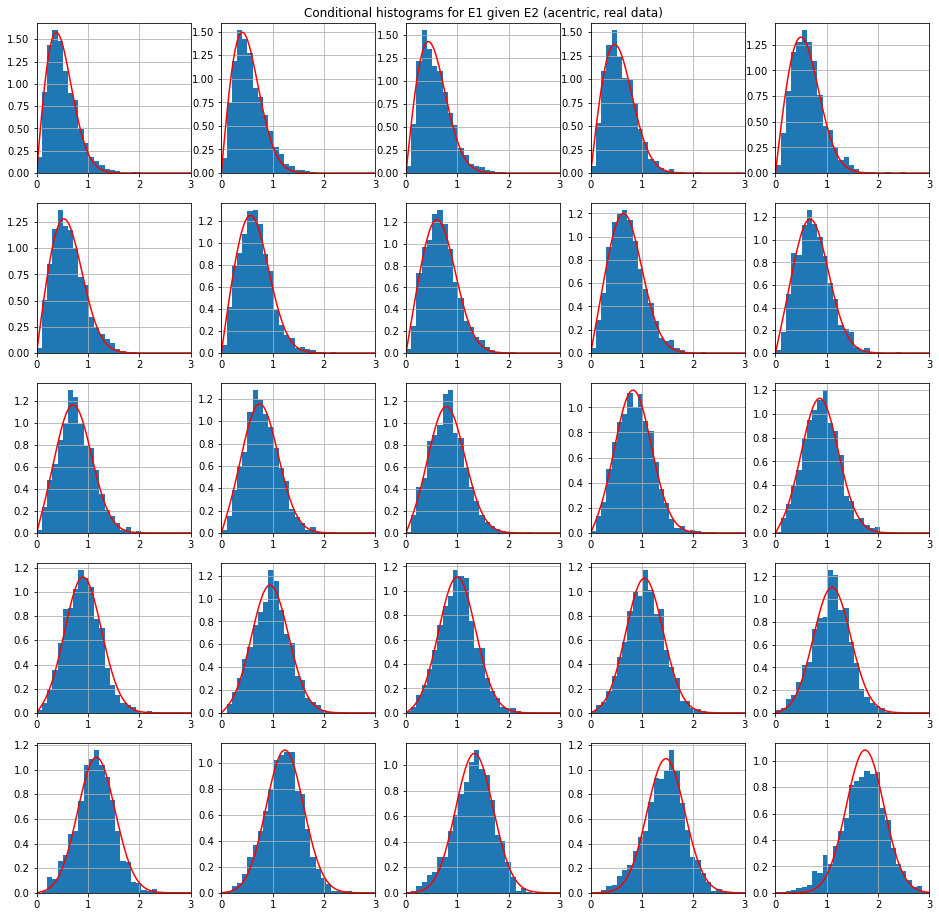

In [156]:
plt.figure(figsize=(16,16))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.85                        # a guess of the corr coef between data sets
    r1  = rho*bin_means_acentric[i]  # conditional exp value of E1 given E2
    cond_var = 0.5*(1-rho**2)        # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric, EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl); plt.grid()

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (acentric, real data)")
plt.show()

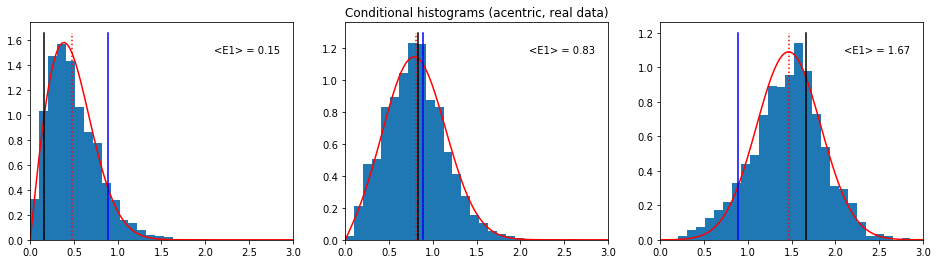

In [158]:
plt.figure(figsize=(16,4))
x=np.linspace(0,3,100)
counter = 0
for i in [1, 13, 24]:
    counter += 1             # for illustration purposes.
    plt.subplot(1,3,counter) # for illustration purposes.
    r_DW = 0.85
    r1 = r_DW*bin_means_acentric[i]     # conditional exp value
    cond_var = 0.5*(1-r_DW**2) # conditional var for acentrics
    
    plt.hist(ds1_2.loc[ds1_2["EP_1_bin"]==i,EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()

#    to illustrate the idea of Rice interpolating between Wilson and delta function:
    plt.plot(bin_means_acentric[i]*np.asarray([1, 1]),yl,'k-')
    plt.plot(rice.mean(0,scale=1/np.sqrt(2))*np.asarray([1,1]),yl,'b-')
    plt.plot(rice.mean(r1/np.sqrt(cond_var),scale=np.sqrt(cond_var))*np.asarray([1,1]),yl,'r:')
    xl=[0,3] #plt.xlim()
    plt.text(2.1,0.9*yl[1],f"<E1> = {bin_means_acentric[i]:.2f}",size=10)
    plt.xlim(xl)
    if counter == 2:
        plt.title("Conditional histograms (acentric, real data)")
 
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

## Conditional distribution for Centrics. Histograms of $|E_2|$ per bin of $|E_1|$.

<ipython-input-160-6931d93c0336>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,5,3)


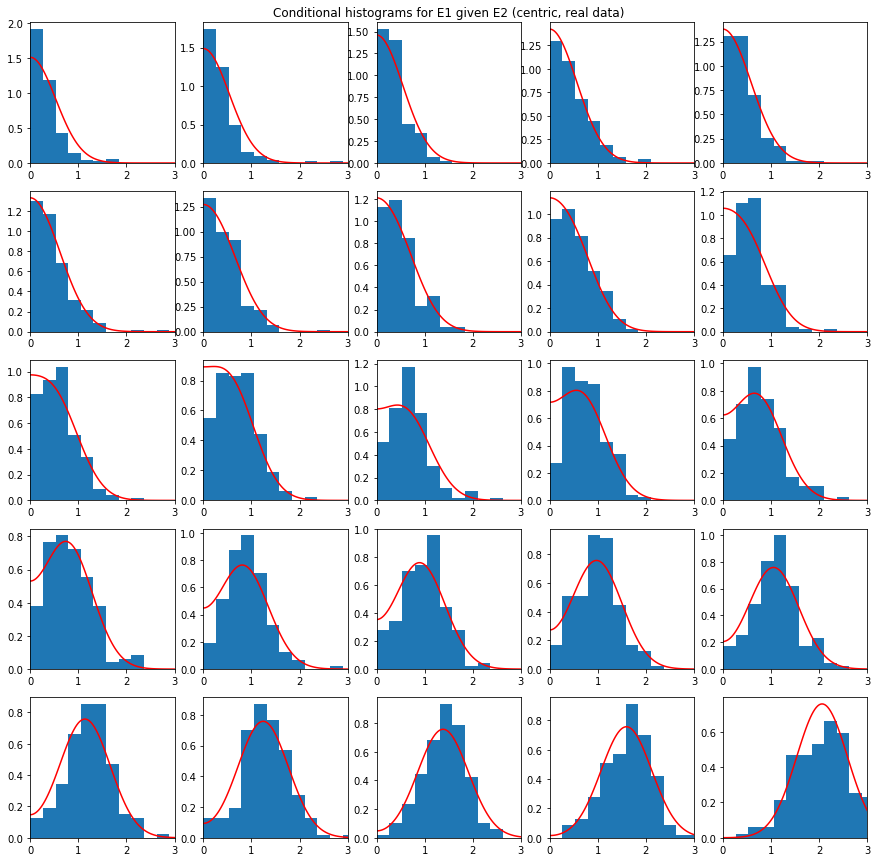

In [160]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.85                       # a guess of the corr coef between data sets
    r1  = rho*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-rho**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_centric,EP2_label],np.linspace(0,5,20),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.show()

## Let's take a look at phases!
Ultimately, this work should set us up to create full conditional distributions of one dataset given another, and to propagate these ideas to refinement.

In [161]:
# ALl "phase keys":
ds1_2.filter(regex="PH").info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 47587 entries, (0, 0, 4) to (28, 7, 6)
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   PHIC_1         47587 non-null  Phase
 1   PHIC_ALL_1     47587 non-null  Phase
 2   PHWT_1         47587 non-null  Phase
 3   PHDELWT_1      47587 non-null  Phase
 4   PHIC_ALL_LS_1  47587 non-null  Phase
 5   PHIC_2         47587 non-null  Phase
 6   PHIC_ALL_2     47587 non-null  Phase
 7   PHWT_2         47587 non-null  Phase
 8   PHDELWT_2      47587 non-null  Phase
 9   PHIC_ALL_LS_2  47587 non-null  Phase
dtypes: Phase(10)
memory usage: 3.8 MB


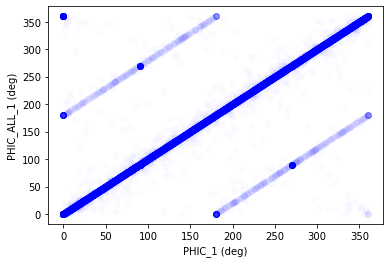

In [162]:
plt.plot(ds1_2["PHIC_1"].to_numpy(),ds1_2["PHWT_1"].to_numpy(),'bo',alpha=0.01)
plt.xlabel("PHIC_1 (deg)")
plt.ylabel("PHIC_ALL_1 (deg)")
plt.show()

not sure what the differences are, but they're all close!

Because of the structure of the Von Mises distribution, the conditional probability of the phase difference of E1 and E2 is a function only of E1 x E2. We'll bin by that. For now, we'll only think about acentrics.

Specifically, the Von Mises distribution (Bricogne, Methods in Enzymology, eq. 1.10) is given by:

$P\left( \varphi | R, r \right) = \frac{1}{2\pi I_0(z)}\exp\left( z \cos(\Delta \varphi)\right)$ 

with $z = \frac{2 r R}{(1-\rho^2)}$

which can also be derived by dividing eq. 14 for $P(R,\varphi | r)$ by eq. 15 for $P(R | r)$ in my current notes. The mapping between the notation of Bricogne and ours is a little awkward. Specifically, $\rho=r_{DW}$, $R=|E2|$ and $r=|E1|$.

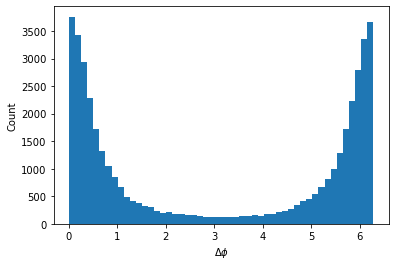

In [163]:
ds1_2["DeltaPHIC"] = np.remainder((np.pi/180.0)*(ds1_2["PHIC_2"].to_numpy()-ds1_2["PHIC_1"].to_numpy()),2*np.pi)
ds1_2["cos(DeltaPHIC)"] = np.cos(ds1_2["DeltaPHIC"])

plt.hist(ds1_2.loc[ds1_2["CENTRIC"]==False, "DeltaPHIC"],50 )
plt.xlabel(r"$\Delta\phi$")
plt.ylabel('Count')
plt.show()

In [164]:
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2["EP1_EP2"]  = ds1_2[EP1_label] * ds1_2[EP2_label]                                 

# For acentrics:
ep12_bins       = np.percentile(ds1_2.loc[ds1_2_acentric, "EP1_EP2"], cdf_bins)
ep12_bins[-1]   = ep12_bins[-1]+1e-6                # to avoid omitting the largest data point
ep12_dig        = np.digitize(ds1_2.loc[  ds1_2_acentric, "EP1_EP2"], ep12_bins)
ds1_2.loc[ds1_2_acentric, "EP1_EP2_bin"] = ep12_dig.flatten()

unique, counts = np.unique(ds1_2.loc[ds1_2_acentric, "EP1_EP2_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)

bin_means_12_acentric = ds1_2[ds1_2_acentric].groupby("EP1_EP2_bin")["EP1_EP2"].mean()                                 

Number of reflections per bin (acentric):
{1.0: 1725, 2.0: 1725, 3.0: 1724, 4.0: 1725, 5.0: 1725, 6.0: 1724, 7.0: 1725, 8.0: 1725, 9.0: 1724, 10.0: 1725, 11.0: 1725, 12.0: 1724, 13.0: 1725, 14.0: 1724, 15.0: 1725, 16.0: 1725, 17.0: 1724, 18.0: 1725, 19.0: 1725, 20.0: 1724, 21.0: 1725, 22.0: 1725, 23.0: 1724, 24.0: 1725, 25.0: 1725}


We again simplify to a single correlation coefficient over the resolution range.

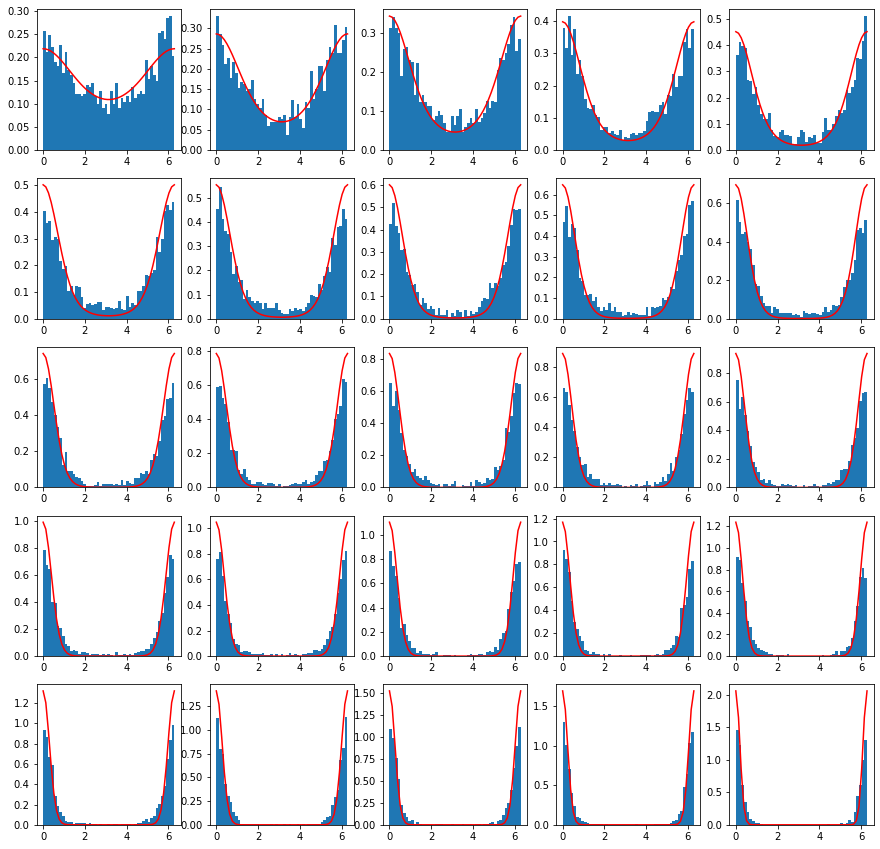

In [165]:
# for acentrics:
plt.figure(figsize=(15,15))
x = np.linspace(0,2*np.pi,50)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.85                          # a guess of the corr coef between data sets
    cond_var = 0.5*(1-rho**2)          # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric, "DeltaPHIC"],np.linspace(0,2*np.pi,50),density=True)
    plt.plot(x, vonmises.pdf(x, bin_means_12_acentric[i]/cond_var),'r-')

plt.show()